# Bayesian PCA
Includes bias and noise.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal


# note that in the function below D should be greater then K
def build_toy_dataset(N, D, K, sigma=1):
    x_train = np.zeros([D, N])
    w = np.zeros([D,K])
    for k in range(K):
        w[k,k]=1.0/(k+1)
        w[k+1,k]=-1.0/(k+1)
    print(w)
    z = np.random.normal(0.0, 1.0, size=(K, N))
    mean = np.dot(w, z)
    shift=np.zeros([D])
    shift[1]=10
    for d in range(D):
      for n in range(N):
        x_train[d, n] = np.random.normal(mean[d, n], sigma)+shift[d]
#     print("True principal axes:")
#     print(w)
#     print("Shift:")
#     print(shift)
    return x_train.astype(np.float32,copy=False)


#ed.set_seed(142)

N = 1000  # number of data points
D = 2  # data dimensionality
K = 1  # latent dimensionality

# DATA

x_train = build_toy_dataset(N, D, K, sigma = 0.1)

[[ 1.]
 [-1.]]


In [2]:
tf.contrib.distributions.__path__

['/home/folzd/anaconda3/lib/python3.5/site-packages/tensorflow/contrib/distributions']

In [3]:
import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

In [4]:
import bijectors as bijector

# The working original version of PPCA
It assumes that
\begin{align}
w_{ij}&\sim N(0,1)\\
z_j&\sim N(0,1)\\
x_i&\sim N((w\cdot z)_i,1)\\
\end{align}

In [5]:
# MODEL

K=1

w = Normal(tf.zeros([D, K]), tf.ones([D, K]))
z = Normal(tf.zeros([K, N]), tf.ones([K, N]))
x = Normal(tf.matmul(w, z),  tf.ones([D, N]))

# INFERENCE
qw = Normal(tf.Variable(tf.random_normal([D, K])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qz = Normal(tf.Variable(tf.random_normal([K, N])),
            tf.nn.softplus(tf.Variable(tf.random_normal([K, N]))))

Run the inference algorithm

In [6]:
inference = ed.KLqp({w: qw, z: qz}, data={x: x_train})
inference.run(n_iter=1000, n_print=100, n_samples=10)

print("Inferred principal axes (columns):")
print(qw.mean().eval())
print(qw.variance().eval())

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 5174.774
Inferred principal axes (columns):
[[-0.08563042]
 [ 8.52902889]]
[[ 0.000946  ]
 [ 0.00178026]]


Although it looks like we are pretty close to the data, the predicted principal directions are completely off now.  This is because the product $W\cdot z$ tries to recreate $W\cdot z+\mu$ with $\(0,10)$ by shifting $z$ away from the center.  This leaves no degrees of freedom in $W$ to recreate the original axis.

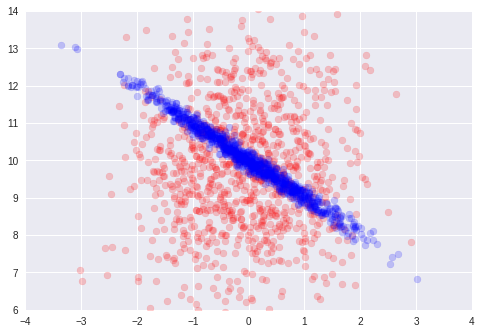

In [7]:
qx = ed.copy(x,{z:qz, w:qw})
plt.scatter(*qx.sample().eval(),c='r',alpha=0.2)
plt.scatter(*x_train,c='b',alpha=0.2)
plt.xlim(-4,4)
plt.ylim(-4+10,4+10)
plt.show()

The variables in the latent space are shifted away from the origin.

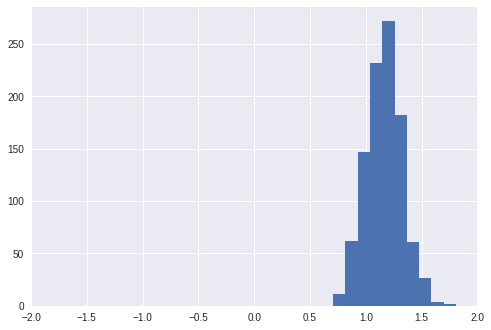

In [8]:
qz_sam=qz.sample().eval()
plt.hist(qz_sam[0])
plt.xlim(-2,2)
plt.show()

## Adding the mean

We add the mean $\mu$ to capture the shift of the data set (the original example assumes data is centered at zero).  The new priors are
\begin{align}
w_{ij}&\sim N(0,1)\\
z_j&\sim N(0,1)\\
\mu_i &\sim N(0,1)\\
x_i&\sim N((w\cdot z)_i+\mu_i,1)\\
\end{align}

### Initial conditions

We also add initial conditions for the approximation of the mean $q_\mu$ as $(q_\mu)_0\sim N(\bar x,1)$, where $\bar x$ is the mean of the data.  This improves the convergence significantly and prevents the latent variable compensation effect visible in the previous example (PCA without the mean).

In [9]:
# MODEL

K=1

w = Normal(tf.zeros([D, K]),    tf.ones([D, K]))
z = Normal(tf.zeros([K, N]),    tf.ones([K, N]))
mu=Normal(tf.zeros([D]),       tf.ones([D]))
x = Normal(tf.matmul(w, z)+tf.transpose(tf.reshape(tf.tile(mu,[N]),[N,D])),
           tf.ones([D, N]))

# INFERENCE
qw = Normal(tf.Variable(tf.random_normal([D, K])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qz = Normal(tf.Variable(tf.random_normal([K, N])),
            tf.nn.softplus(tf.Variable(tf.random_normal([K, N]))))

# initial conditions for qmu, improves convergence
data_mean = np.mean(x_train,axis=1).astype(np.float32,copy=False)

qmu=Normal(tf.Variable(data_mean+tf.random_normal([D])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

In [10]:
inference = ed.KLqp({w: qw, z: qz, mu: qmu}, data={x: x_train})
inference.run(n_iter=1000, n_print=100, n_samples=10)

print("Inferred principal axes (columns):")
print(qw.mean().eval())
print(qw.variance().eval())
print("Inferred center:")
print(qmu.mean().eval())
print(qmu.variance().eval())

1000/1000 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 2678.846
Inferred principal axes (columns):
[[-0.60704815]
 [ 0.59682369]]
[[ 0.00104454]
 [ 0.00101364]]
Inferred center:
[  1.51779782e-03   9.99811459e+00]
[ 0.00098785  0.00104699]


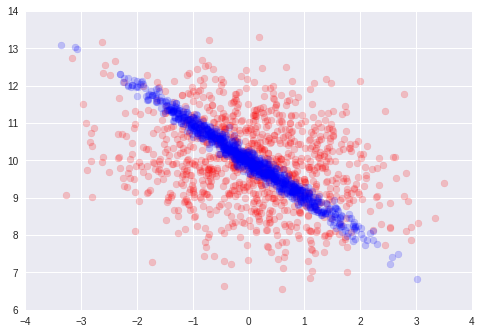

In [11]:
qx = ed.copy(x,{z:qz, w:qw, mu:qmu})
plt.scatter(*qx.sample().eval(),c='r',alpha=0.2)
plt.scatter(*x_train,c='b',alpha=0.2)
plt.xlim(-4,4)
plt.ylim(-4+10,4+10)
plt.show()

Now the variables in the latent space are centered!

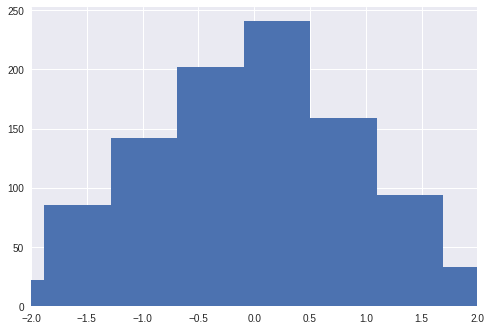

In [12]:
qz_sam=qz.sample().eval()
plt.hist(qz_sam[0])
plt.xlim(-2,2)
plt.show()

## Adding the noise variance (LogNormal posterior)

Now we add the variance $\sigma$ to get the width of the distribution around the line.  The new priors are
\begin{align}
w_{ij}&\sim N(0,1)\\
z_j&\sim N(0,1)\\
\mu_i &\sim N(0,1)\\
\sigma &\sim Gamma(1,1)\\
x_i&\sim N((w\cdot z)_i+\mu_i,\sigma)\\
\end{align}

In [13]:
# MODEL

K=1

ds = tf.contrib.distributions

sigma = ed.models.Gamma(1.0,1.0)

w = Normal(tf.zeros([D, K]),    tf.ones([D, K]))
z = Normal(tf.zeros([K, N]),    tf.ones([K, N]))
mu=Normal(tf.zeros([D]),       tf.ones([D]))
x = Normal(tf.matmul(w, z)+
           tf.transpose(tf.reshape(tf.tile(mu,[N]),[N,D])), sigma*tf.ones([D, N]))

# INFERENCE
qw = Normal(tf.Variable(tf.random_normal([D, K])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qz = Normal(tf.Variable(tf.random_normal([K, N])),
            tf.nn.softplus(tf.Variable(tf.random_normal([K, N]))))

# initial conditions for qmu, improves convergence
data_mean = np.mean(x_train,axis=1).astype(np.float32,copy=False)

qmu =  Normal(tf.Variable(data_mean+tf.random_normal([D])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

qsigma = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(0.0),
                                  tf.Variable(1.0)),
    bijector=bijector.Exp(),
    name="LogNormalTransformedDistribution")

inference = ed.KLqp({w: qw, z: qz, mu: qmu, sigma: qsigma}, data={x: x_train})
inference.run(n_iter=10000, n_samples=10)

print("Inferred principal axes (columns):")
print(qw.mean().eval())
print(qw.variance().eval())
print("Inferred center:")
print(qmu.mean().eval())
print(qmu.variance().eval())

10000/10000 [100%] ██████████████████████████████ Elapsed: 33s | Loss: 941.340
Inferred principal axes (columns):
[[ 0.92990452]
 [-0.92224783]]
[[  8.29934579e-05]
 [  2.00562936e-05]]
Inferred center:
[ -3.85201792e-03   9.99919224e+00]
[  8.45807081e-05   3.58949292e-05]


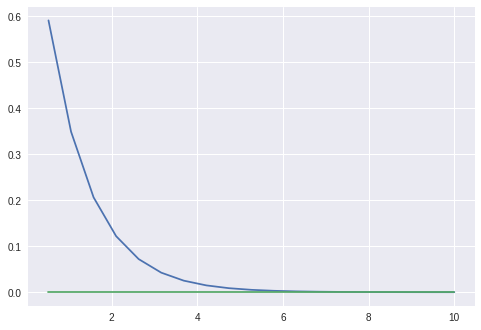

In [14]:
var_range = np.linspace(0,10,20,dtype=np.float32)
plt.plot(var_range,sigma.prob(var_range).eval())
plt.plot(var_range,qsigma.prob(var_range).eval())
plt.show()

Note that the loss function is much smaller now but we needed more iterations to converge.

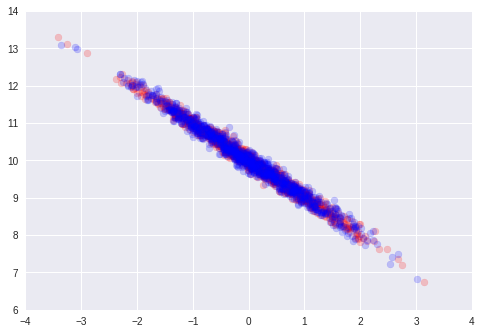

In [15]:
qx = ed.copy(x,{z:qz, w:qw, mu:qmu, sigma:qsigma})
plt.scatter(*qx.sample().eval(),c='r',alpha=0.2)
plt.scatter(*x_train,c='b',alpha=0.2)
plt.xlim(-4,4)
plt.ylim(-4+10,4+10)
plt.show()

The distribution of $\sigma$ should be close to $0.1$ that we started with.

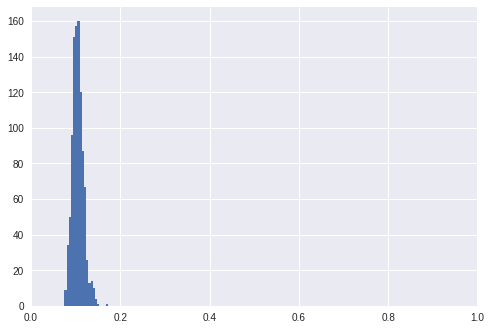

In [16]:
plt.hist(qsigma.sample(1000).eval(),bins=20)
plt.xlim(0,1)
plt.show()

## Adding the automatic relevance determination.

So far we used the knowledge on the dimensionality of the latent space by setting $K=1$.  We can determine the number of latent dimensions by setting a higher $K$ (in this case $K=2$) and adding another prior $\alpha=(\alpha_1,\dots,\alpha_K)$ for the scale of each dimension.
\begin{align}
\alpha_j&\sim Gamma(1,1)\\
w_{ij}&\sim N(0,\alpha_j)\\
z_j&\sim N(0,1)\\
\mu_i &\sim N(0,1)\\
\sigma &\sim Gamma(1,1)\\
x_i&\sim N((w\cdot z)_i+\mu_i,\sigma)\\
\end{align}

We expect the posterior for either $\alpha_1$ or $\alpha_2$, say $\alpha_2$, to drop down to zero, signaling that there are is only one significant dimension left, $\alpha_1\ne0$.

In [17]:
# MODEL

K=2

ds = tf.contrib.distributions

sigma = ed.models.Gamma(1.0,1.0)

alpha = ed.models.Gamma(tf.ones([K]),tf.ones([K]))
w = Normal(tf.zeros([D, K]),    tf.reshape(tf.tile(alpha,[D]),[D,K]))
z = Normal(tf.zeros([K, N]),    tf.ones([K, N]))
mu= Normal(tf.zeros([D]),       tf.ones([D]))
x = Normal(tf.matmul(w, z)+
           tf.transpose(tf.reshape(tf.tile(mu,[N]),[N,D])), sigma*tf.ones([D, N]))

# INFERENCE
qalpha = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.zeros([K])),
                                                   tf.Variable(tf.ones([K]))),
    bijector=bijector.Exp(),
    name="qalpha")

qw = Normal(tf.Variable(tf.random_normal([D, K])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qz = Normal(tf.Variable(tf.random_normal([K, N])),
            tf.nn.softplus(tf.Variable(tf.random_normal([K, N]))))

# initial conditions for qmu, improves convergence
data_mean = np.mean(x_train,axis=1).astype(np.float32,copy=False)

qmu= Normal(tf.Variable(data_mean+tf.random_normal([D])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

qsigma = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(0.0),
                                  tf.Variable(1.0)),
    bijector=bijector.Exp(),
    name="qsigma")

inference = ed.KLqp({alpha: qalpha, w: qw, z: qz, mu: qmu, sigma: qsigma}, data={x: x_train})
inference.run(n_iter=10000, n_samples=10)

print("Inferred principal axes (columns):")
print(qw.mean().eval())
print(qw.variance().eval())
print("Inferred center:")
print(qmu.mean().eval())
print(qmu.variance().eval())

10000/10000 [100%] ██████████████████████████████ Elapsed: 72s | Loss: 915.798
Inferred principal axes (columns):
[[  9.27190125e-01  -1.95524717e-05]
 [ -9.19576049e-01  -1.62992001e-05]]
[[  1.72253949e-05   3.42139356e-05]
 [  1.71397714e-05   2.04429216e-05]]
Inferred center:
[ -3.75223113e-03   9.99920750e+00]
[  1.05028612e-05   1.45708445e-05]


With this step the loss function should be comparable to the previous example but we removed one of the parameters of the model (the number of latent dimensions).

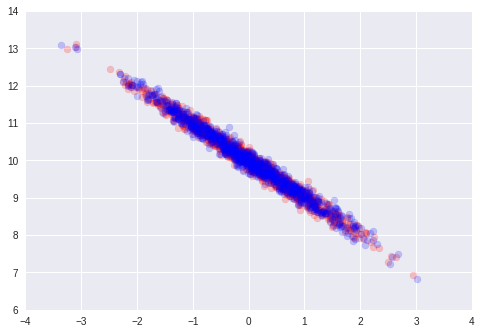

In [18]:
qx = ed.copy(x,{alpha: qalpha, z:qz, w:qw, mu:qmu, sigma:qsigma})
plt.scatter(*qx.sample().eval(),c='r',alpha=0.2)
plt.scatter(*x_train,c='b',alpha=0.2)
plt.xlim(-4,4)
plt.ylim(-4+10,4+10)
plt.show()

The distribution of $\sigma$ should be close to $0.1$ that we started with.

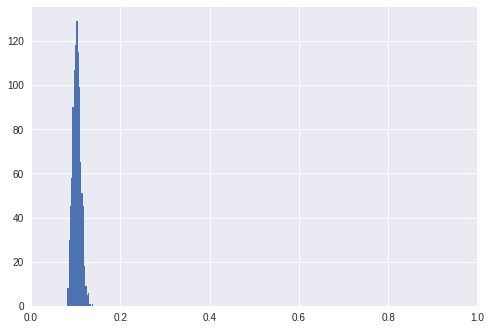

In [19]:
plt.hist(qsigma.sample(1000).eval(),bins=20)
plt.xlim(0,1)
plt.show()

As expected, one of the $\alpha_j$ collapses to $0$, while the other stays close to $1$.

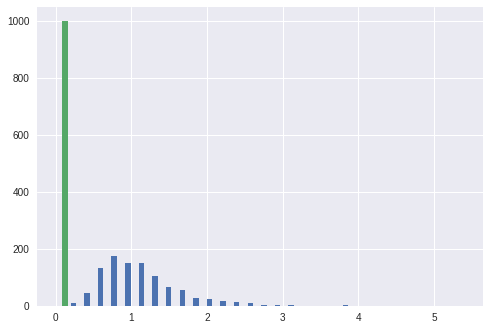

In [20]:
plt.hist(qalpha.sample(1000).eval(),bins=30)
plt.show()

### The automatic relevance determination in higher dimensions

The ARD might seem like an overkill but it comes in handy in higher dimensions, where the dimensionality of the latent space is not a prior known.  Let us generate a higher dimensional data set and see how ARD determines the latent dimensionality.

In [21]:
# DATA

Dhigh = 10
Ktrue = 3

x_high = build_toy_dataset(N, Dhigh, Ktrue, sigma = 0.1)

[[ 1.          0.          0.        ]
 [-1.          0.5         0.        ]
 [ 0.         -0.5         0.33333333]
 [ 0.          0.         -0.33333333]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


In [22]:
# MODEL

D=Dhigh
K=D

ds = tf.contrib.distributions

sigma = ed.models.Gamma(1.0,1.0)

alpha = ed.models.Gamma(tf.ones([K]),tf.ones([K]))
w = Normal(tf.zeros([D, K]),    tf.reshape(tf.tile(alpha,[D]),[D,K]))
z = Normal(tf.zeros([K, N]),    tf.ones([K, N]))
mu = Normal(tf.zeros([D]),       tf.ones([D]))
x = Normal(tf.matmul(w, z)+
           tf.transpose(tf.reshape(tf.tile(mu,[N]),[N,D])), sigma*tf.ones([D, N]))

# INFERENCE
qalpha = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(tf.random_normal([K])),
                                                   tf.Variable(tf.random_normal([K]))),
    bijector=bijector.Exp(),
    name="qalpha")

qw = Normal(tf.Variable(tf.random_normal([D, K])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qz = Normal(tf.Variable(tf.random_normal([K, N])),
            tf.nn.softplus(tf.Variable(tf.random_normal([K, N]))))

# initial conditions for qmu, improves convergence
data_mean = np.mean(x_high,axis=1).astype(np.float32,copy=False)

qmu = Normal(tf.Variable(data_mean+tf.random_normal([D])),
            tf.nn.softplus(tf.Variable(tf.random_normal([D]))))

qsigma = ed.models.TransformedDistribution(
    distribution=ed.models.NormalWithSoftplusScale(tf.Variable(0.0),
                                  tf.Variable(1.0)),
    bijector=bijector.Exp(),
    name="qsigma")

inference = ed.KLqp({alpha: qalpha, w: qw, z: qz, mu: qmu, sigma: qsigma}, data={x: x_high})
inference.run(n_iter=10000, n_samples=10)

print("Inferred principal axes (columns):")
print(qw.mean().eval())
print(qw.variance().eval())
print("Inferred center:")
print(qmu.mean().eval())
print(qmu.variance().eval())

10000/10000 [100%] ██████████████████████████████ Elapsed: 129s | Loss: 4802.462
Inferred principal axes (columns):
[[  8.43453500e-03   1.65454261e-02   7.88543165e-01   5.67732798e-03
    2.62386471e-01   1.71880273e-03  -1.22942282e-02   1.41741324e-03
   -1.37577381e-03  -2.50468031e-03]
 [  3.42158019e-03   5.42571396e-03  -1.00857723e+00   4.83288546e-04
    4.39542755e-02  -5.60539681e-03   3.91755195e-04   2.20011477e-03
   -3.90074775e-03   1.36798527e-03]
 [ -1.56616326e-02  -3.02507989e-02   2.46347457e-01  -8.97979457e-03
   -4.24756914e-01   3.88697907e-03   1.83459483e-02  -5.68654528e-03
    5.13948686e-03   3.31083499e-03]
 [  3.14774970e-03   7.83518050e-03  -1.80048458e-02   2.96476297e-03
    1.21304050e-01   1.70112471e-04  -7.30547681e-03   1.57145143e-03
   -9.30122187e-05  -2.17729760e-03]
 [  1.31354929e-04   4.06540967e-05  -4.96475201e-04  -4.21358745e-05
   -1.03836320e-03  -2.13518622e-04   3.75890493e-04   1.03441198e-06
    6.49717040e-05   2.24510935e-04]

In [23]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [30]:
tmp= qw.mean().eval()

In [32]:
tmp[abs(tmp)>0.1]

array([ 0.78854316,  0.26238647, -1.00857723,  0.24634746, -0.42475691,
        0.12130405], dtype=float32)

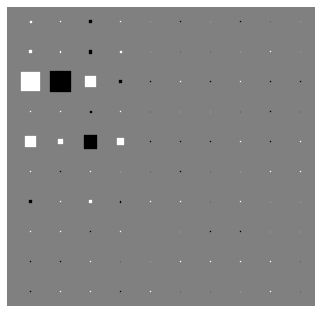

In [24]:
hinton(qw.mean().eval())
plt.show()

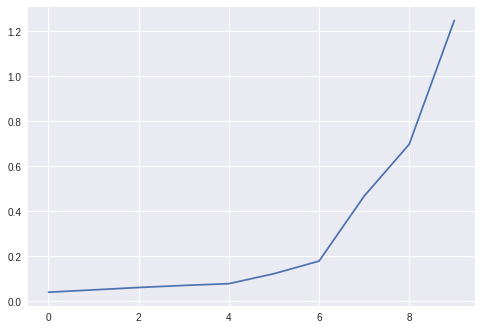

In [25]:
alphas=tf.exp(qalpha.distribution.mean()).eval()
alphas.sort()
plt.plot(range(alphas.size),alphas)
plt.show()

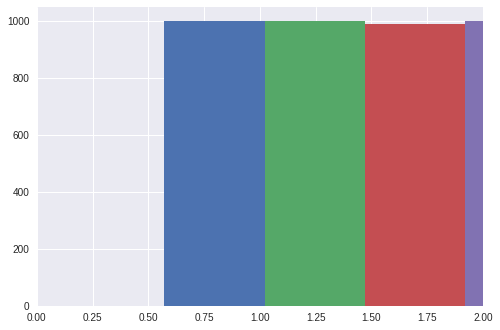

In [26]:
plt.hist(qalpha.sample(1000).eval(),bins=20)
plt.xlim(0,2)
plt.show()

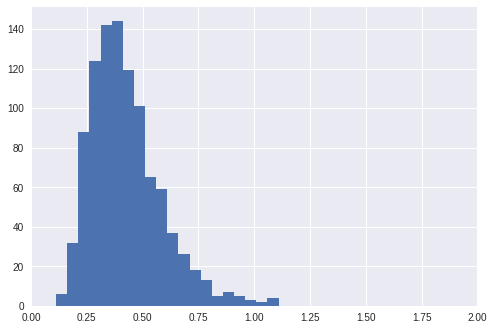

In [27]:
plt.hist(qsigma.sample(1000).eval(),bins=20)
plt.xlim(0,2)
plt.show()